In [3]:
import IPython
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack
from scipy.ndimage import convolve
from scipy.fftpack import dct, dctn, idctn
from scipy.linalg import circulant
import pywt
from sklearn import linear_model
from IPython.display import clear_output, display
import seaborn as sns

In [4]:
sns.__version__

'0.11.0'

In [5]:
import matplotlib as mpl
mpl.rc('image', cmap='Blues')

In [6]:
width = 128
# img = cv2.imread('./spine_mra.jpg',0)
img = cv2.imread('./SheppLogan_Phantom.png',0)
img = cv2.resize(img, dsize=(width,width))
# img = cv2.imread('/Users/hamid/Projects/DoE/skull_base.png',0)
# img = cv2.imread('/Users/hamid/Projects/DoE/stem.png',0)
# img = cv2.imread('/Users/hamid/Projects/DoE/spine.png',0)
# img = cv2.imread('/Users/hamid/Projects/DoE/lumbar_spine.png',0)
# img = cv2.imread('/Users/hamid/Projects/DoE/spine_mra.jpg',0)

In [7]:
def sparsity(img):
    return (np.sum(np.abs(img) > 1e-9) / np.prod(img.shape))

In [8]:
def print_progress(n, i):
    
    if i % (n // 100) == 0:
        clear_output(wait=True)
        print((i + 1) * 100 // n_reps, "% done")

0.06317138671875


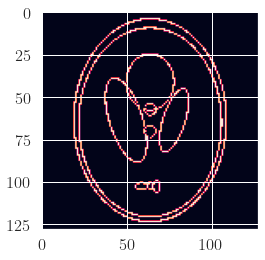

In [121]:
thresh = 0
lap = cv2.Laplacian(img,cv2.CV_64F,ksize=1)
lap_th = np.copy(lap)
lap_th[lap_th < thresh] = 0
lap_th[lap_th != 0] = 1
plt.imshow(lap_th)
print(sparsity(lap_th))
plt.imsave('shep_lap.png', lap_th, format="png", cmap='gray', vmin=0)

In [10]:
N = np.prod(img.shape)
p = N
print('shape: ', img.shape)
print('dim: ', p)
print('sparsity: ', sparsity(img))

shape:  (128, 128)
dim:  16384
sparsity:  0.42742919921875


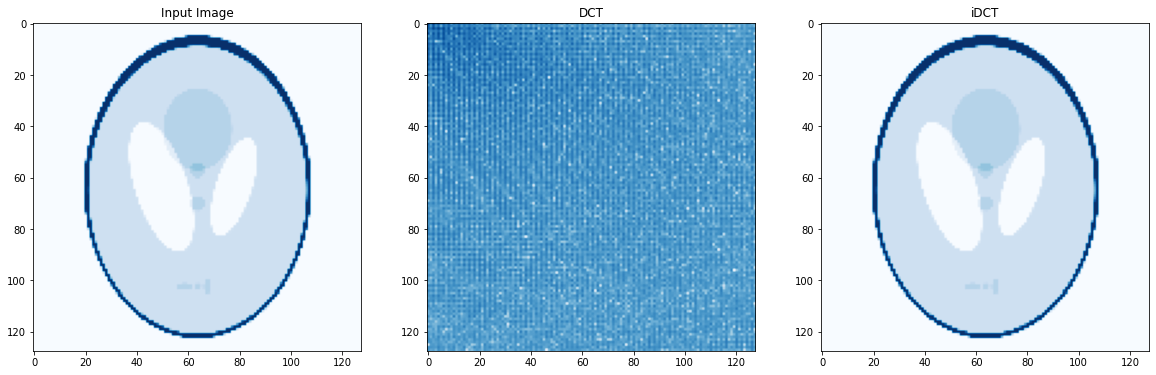

In [11]:
C = dctn(img, norm='ortho')
# Cshift = np.log(np.abs(np.fft.fftshift(C)))
invC = idctn(C, norm='ortho')
plt.figure(figsize=(20,20))
plt.subplot(131),plt.imshow(img)
plt.title('Input Image')
plt.subplot(132),plt.imshow(np.log(np.abs(C)))
plt.title('DCT')
plt.subplot(133), plt.imshow(invC)
plt.title('iDCT')
plt.show()

In [12]:
d = dct(np.eye(img.shape[0]), norm='ortho')
D = np.kron(d,d).T

In [13]:
X = np.sqrt(N) * D.copy()

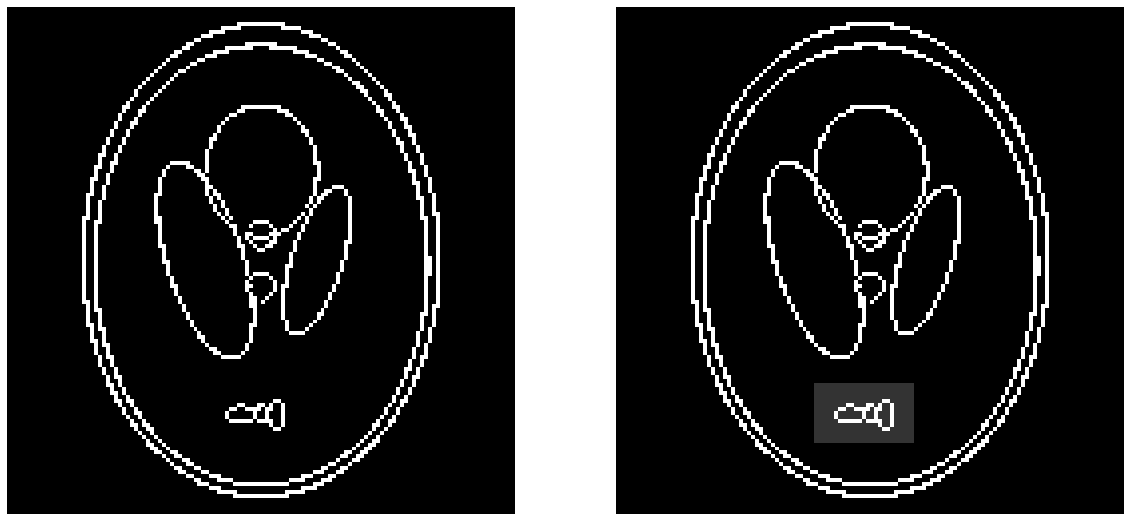

In [115]:
c_arr = np.zeros(img.shape)
c_arr[95:110, 50:75] = 1
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(lap_th, vmin=0, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(np.minimum(lap_th + 0.2*c_arr, 1), vmin=0, cmap='gray')
plt.axis('off')
plt.savefig('shepp_lap_filter.png', format="png", cmap='gray', vmin=0, dpi=700, bbox_inches='tight')

In [122]:
(95 - 110) * (50 - 75)

375

In [15]:
c_wt = pywt.wavedec2(c_arr, 'haar', level=2)
c, _ = pywt.coeffs_to_array(c_wt)
c = c.reshape(N)
c = c / np.linalg.norm(c)

In [16]:
N = np.prod(img.shape)
beta = lap_th.reshape(N)
c = c_arr.reshape(N)
c = c / np.sum(np.abs(c))
beta.T @ c

0.10666666666666666

In [ ]:
import cvxpy as cp

In [ ]:
# N = np.prod(img.shape)

# w = cp.Variable((N), nonneg=True)
# alpha = 0.001
# sdp_const = X.T @ cp.diag(w) @ X - alpha * np.eye(N) >> 0
# constraints = [cp.sum(w) == 1]
# obj = cp.Minimize(cp.MatrixFrac(np.ones(N)/np.sqrt(N), X.T @ cp.diag(w) @ X))
# prob = cp.Problem(obj, constraints)

In [ ]:
# prob.solve(verbose = True)

In [ ]:
N = np.prod(img.shape)
w = cp.Variable((N), nonneg = True)
z = cp.Variable((N))
constraints = [X.T @ z == c, z - w <= 0, -z - w <= 0]
obj = cp.Minimize(cp.sum(w))
prob = cp.Problem(obj, constraints)

In [ ]:
prob.solve(verbose = True, abstol = 1e-5)

In [ ]:
w_opt = w.value / np.sum(w.value)

In [ ]:
np.savetxt("w_opt.csv", w_opt, delimiter=",")

In [ ]:
w_opt[w_opt < 0]

## Read optimal weights

In [17]:
w_opt = np.loadtxt("w_opt.csv", delimiter=",")

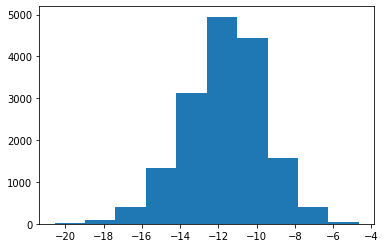

In [18]:
plt.hist(np.log(w_opt[w_opt > 0]))
plt.show()

In [19]:
sigma_opt = np.sqrt(c.T @ np.linalg.solve( X.T @ np.diag(w_opt) @ X, c))

In [20]:
sigma_unif = np.sqrt(c.T @ np.linalg.solve( X.T @ X / N, c))

In [21]:
(sigma_unif / sigma_opt)

4.974722710380465

In [ ]:
np.linalg.eigvalsh(X.T @ np.diag(w_opt) @ X)

In [ ]:
np.isclose(X.T @ X / N, np.eye(N))

In [22]:
from sklearn.linear_model import Lasso, LassoCV
from random import sample

In [23]:
def deb_lasso(x, y, c, u, lasso_tuning, beta_init):
    n = len(y)
    clf = Lasso(alpha=lasso_tuning, fit_intercept=False,
               warm_start=True, max_iter = 999999, copy_X = True,
                normalize = False)
    norms = np.sqrt(np.mean(x**2, axis = 0))
    clf.coef_ = beta_init  #Initialize at truth for faster computation
    clf.fit(x / norms, y)
    beta_hat = clf.coef_ / norms
    gamma_hat = c.T @ beta_hat + u.T @ x.T @ (y - x @ beta_hat) / n
    return [gamma_hat, beta_hat]

In [24]:
signal = X @ beta

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 5 concurrent workers.
...........................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.7min finished


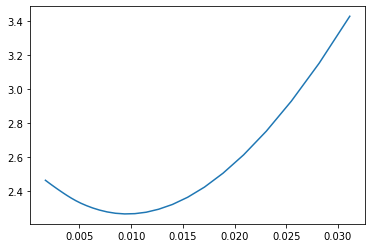

In [53]:
n = N // 2
lambda_theory = np.sqrt(np.log(N)/ n)
indices = np.random.choice(range(N), size=n)

y = signal[indices] + np.random.normal(size=n)

lasso_fit = LassoCV(cv = 10, fit_intercept=False, 
                    alphas=(np.exp(np.arange(-3, 0, 1e-1)))*lambda_theory,
                    n_jobs = -1, max_iter = 999999, verbose=True).fit(X[indices,:],y)

plt.plot(lasso_fit.alphas_, np.mean(lasso_fit.mse_path_, axis = 1))
plt.show()

In [55]:
beta_hat = lasso_fit.coef_
print(gamma)
print("Error: ", np.sum(np.abs(beta - beta_hat)))
print(np.sum(beta))
print(lambda_theory, lasso_fit.alpha_)
cv_lambda = lasso_fit.alpha_

0.10666666666666666
Error:  44.61642271034549
1035.0
0.03441769459380233 0.009379916019746007


# Uniform Sampling

In [29]:
n = N // 2
lambda_theory = np.sqrt(np.log(N)/ n)
u_unif = c
gamma = c.T @ beta

In [57]:
gamma

0.10666666666666666

In [60]:
n = N // 2
n_reps = 500
gammas_unif = np.zeros(n_reps)
signal = X @ beta
beta_hat = np.zeros(N)

for i in range(n_reps):
    indices = np.random.choice(range(N), size=n)
    y = signal[indices] + np.random.normal(size=n)    
    gammas_unif[i], beta_hat = deb_lasso(X[indices,:], y, c, u_unif, cv_lambda, beta_hat.copy())
    
    print_progress(n_reps, i)
    

98 % done


In [67]:
# np.savetxt(fname = 'unif_dist.csv', X = gammas_unif, delimiter = ',')

In [60]:
gammas_unif = np.loadtxt('unif_dist.csv', delimiter=',')

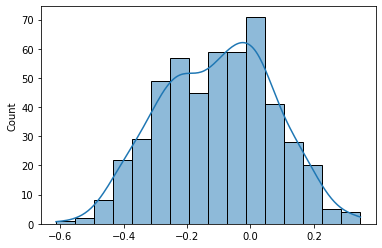

bias:  -0.00115171559733028
std:  0.0019342389201397066
0.0005705443307345479


In [63]:
sns.histplot(np.sqrt(n) * (gammas_unif - gamma), kde=True)
plt.show()
print("bias: ", np.mean(gammas_unif) - gamma)
print("std: ", np.std(gammas_unif))
print((np.linalg.norm(c) / np.sqrt(n)))

# Optimal Sampling

In [69]:
u_opt = np.linalg.solve(X.T @ np.diag(w_opt) @ X, c)

In [73]:
n_reps = 500
gammas_opt = np.zeros(n_reps)
beta_hat = np.zeros(N)
for i in range(n_reps):
    indices = np.random.choice(range(N), size=n, p=w_opt)
    y = signal[indices] + np.random.normal(size=n)

    gammas_opt[i], beta_hat = deb_lasso(X[indices,:], y, c, u_opt, cv_lambda, beta_hat.copy())
    
    print_progress(n_reps, i)
    print(gammas_opt[i] - gamma)

99 % done
-0.0001352273716913599
0.00019388917591393884
-6.57882654799824e-05
3.834638347958996e-05
-0.000164801941135162


In [74]:
# np.savetxt("opt_dist.csv", gammas, delimiter=",")

In [55]:
gammas_opt = np.loadtxt("opt_dist.csv", delimiter=',')

bias:  4.1564830656023976e-05
s.e.:  0.008825489007543307


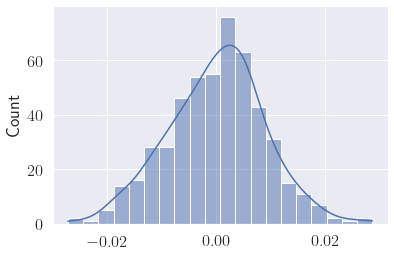

In [117]:
sns.histplot(np.sqrt(n)*(gammas_opt - gamma), kde=True)
print('bias: ', np.sqrt(n) * (np.mean(gammas_opt) - gamma))
print('s.e.: ', np.sqrt(n) * np.std(gammas_opt))

In [ ]:
np.random.choice(range(10), 5)

In [ ]:
np.sum(np.isclose(w_opt, 0)) / N

In [ ]:
def grad(w, X, alpha, c):
    N = X.shape[0]
    Sigma = X.T @ np.diag(w) @ X
    u1 = c.T @ np.linalg.solve(Sigma, X.T)
    u2 = np.diag(X @ np.linalg.solve((Sigma - alpha * np.eye(N)), X.T))
    return -(u1 ** 2) - u2 / (N**2)

In [ ]:
def proj(y):
    N = len(y)
    u = sorted(y, reverse=True)
    v = np.cumsum(u)
    rho = np.where( (u + (1 - v)/(np.arange(N)+1)) >0)[0][-1]
    lam = (1 - v[rho])/(rho+1)
    return (y + lam) * ((y + lam)>0)

In [ ]:
n_iter = 1
step_size = 1e-3
alpha = 0.01
# w = np.ones(N) / N
for i in range(n_iter):
    g = grad(w, X, alpha, c)
    u = w - step_size * g / np.linalg.norm(g)
    print(np.max(np.abs(u)))
    w = proj(u)

In [25]:
unif_dist = np.loadtxt('unif_dist.csv', delimiter=',')
opt_dist = np.loadtxt('opt_dist.csv', delimiter=',')

bias:  -0.1042413963354312
s.e.:  0.17506732247881365


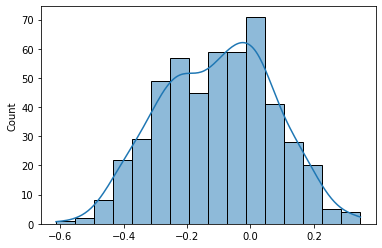

In [52]:
print('bias: ', np.sqrt(n) * (np.mean(unif_dist) - gamma))
print('s.e.: ', np.sqrt(n) * np.std(unif_dist))
sns.histplot(np.sqrt(n) * (unif_dist - gamma), kde=True)
plt.show()

In [54]:
indices = np.random.choice(range(N), size=n, p=w_opt)
print("s.e.: ", np.sqrt(c.T @ (X[indices,:].T @ X[indices,] / n) @ c))
print("Asymptotic s.e.: ", np.sqrt(c.T @ c))

s.e.:  0.47354139297294645
Asymptotic s.e.:  0.05163977794943222


In [108]:
sns.set(font_scale=1.5, rc={'text.usetex' : True})


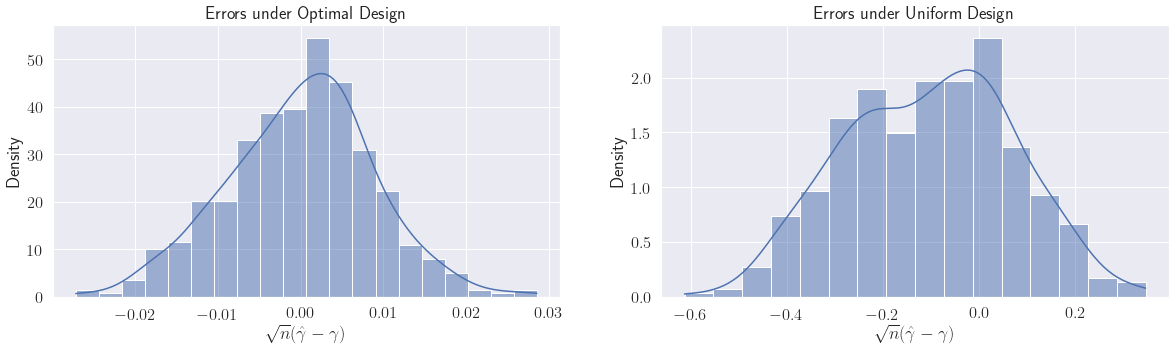

In [114]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("Errors under Optimal Design")
plt.xlabel(r'$\sqrt{n} (\hat{\gamma} - \gamma)$')
sns.histplot(np.sqrt(n) * (gammas_opt - gamma), kde=True, stat='density')
plt.subplot(122)
plt.title("Errors under Uniform Design")
plt.xlabel(r'$\sqrt{n} (\hat{\gamma} - \gamma)$')
sns.histplot(np.sqrt(n) * (unif_dist - gamma), kde=True, stat='density')
plt.savefig('hist_compare.png', dpi=700, bbox_inches='tight')